# Final Project : Structure Formation

This program will analyze a dataset from the survey of the Baryon Oscillation Spectroscopic Survey (BOSS). We take a map in the $(RA,DEC,z)$ to cartesian coordinates $(x,y,z)$.Then we measure the power spectrum, calculate the covariance matrices. Extract the BAO and to de the MCMC to extract the cosmological information and a $\alpha$ scalling parameter. Here we take galaxies with redshift $z=0.5$ and $z=0.75$.

To re-compile this notebook, you might to install the nbodikit library with :
1. pip install nbodykit
For more info about this pacckage might be found in https://nbodykit.readthedocs.io/en/latest/index.html

2. And the dataset of the BOSS can be downloaded:
    
    The data and corresponding random BOSS dataset (Two files for North and South)
     
     wget -N https://data.sdss.org/sas/dr12/boss/lss/galaxy_DR12v5_CMASSLOWZTOT_North.fits.gz -P Data
 
     wget -N https://data.sdss.org/sas/dr12/boss/lss/galaxy_DR12v5_CMASSLOWZTOT_South.fits.gz -P Data
 
     wget -N https://data.sdss.org/sas/dr12/boss/lss/random0_DR12v5_CMASSLOWZTOT_North.fits.gz -P Data
 
     wget -N https://data.sdss.org/sas/dr12/boss/lss/random0_DR12v5_CMASSLOWZTOT_South.fits.gz -P Data
 
     The simulated BOSS datasets

     wget -N https://data.sdss.org/sas/dr12/boss/lss/dr12_multidark_patchy_mocks/Patchy-Mocks-DR12SGC-COMPSAM_V6C.tar.gz -P Data
 
     wget -N https://data.sdss.org/sas/dr12/boss/lss/dr12_multidark_patchy_mocks/Patchy-Mocks-DR12NGC-COMPSAM_V6C.tar.gz -P Data
 
     wget -N https://data.sdss.org/sas/dr12/boss/lss/dr12_multidark_patchy_mocks/Patchy-Mocks-Randoms-DR12SGC-COMPSAM_V6C_x50.tar.gz -P Data
 
     wget -N https://data.sdss.org/sas/dr12/boss/lss/dr12_multidark_patchy_mocks/Patchy-Mocks-Randoms-DR12NGC-COMPSAM_V6C_x50.tar.gz -P Data

3. With this notebook, it will come with pk * .pickle, which you need to put in a Data / sims / directory. The pk files are simulated power spectra that we need to calculate covariance matrices.

## First the libraries

In [1]:
%matplotlib inline
import sys, platform, os
import itertools
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import scipy.optimize as op
import scipy.interpolate as interp
from classy import Class # to plot power spectrum with z=0
import nbodykit.lab
import pandas as pd
import emcee
import mpi3
import corner
import pickle
from numpy.linalg import inv
from matplotlib.ticker import MaxNLocator
from scipy.constants import speed_of_light
plt.rcParams['figure.figsize'] = [12,8]


1. Set the cosmology $\Lambda CDM$ and Constants

In [3]:
# set a cosmology to the analisys of the data
cosmo = nbodykit.lab.cosmology.Cosmology(Omega0_cdm=0.26185743, Omega0_b=0.04814257, h=0.6774)


In [2]:
# Constants
zmin = 0.5
zmax = 0.75
zmean = 0.61 # see calculation in read_data()
kmin = 0.01
kmax = 0.3

base_dir = 'Data/'
output_path = base_dir

2. Plot the maps and distribution of the BOSS catalogue

In [4]:
#function to read the data
def read_data(filename):
    ''' Here we read the data catalogues '''
    galaxies_cat = nbodykit.lab.FITSCatalog(os.path.join(base_dir, filename))
    print('galaxies_cat.columns = ', galaxies_cat.columns)
    galaxies_cat = galaxies_cat[(galaxies_cat['Z'] > zmin) & (galaxies_cat['Z'] < zmax)]
    galaxies_cat['Weight'] = galaxies_cat['WEIGHT_SYSTOT'] * (galaxies_cat['WEIGHT_NOZ'] + galaxies_cat['WEIGHT_CP'] - 1.0)
    #zmean = np.average(galaxies_cat['Z'].compute(), weights=(galaxies_cat['Weight']*galaxies_cat['WEIGHT_FKP']).compute())
    return galaxies_cat

def down_sample(cat, N):
    x = np.random.uniform(size=cat.size)
    return cat[x < float(N) / cat.size]

def plot_data(cat1, cat2):
    ''' Plot the catalogues '''
    cat1 = down_sample(cat1, 1000)
    cat1['RA'] -= 180
    cat2 = down_sample(cat2, 1000)
    cat2['RA'] -= 180
    
    #plot the distrubition of galaxies
    plt.clf()
    plt.subplot(projection="aitoff")
    plt.title("BOSS DR12 survey footprint", y=1.1)
    plt.plot(np.radians(cat1['RA'].compute()), np.radians(cat1['DEC'].compute()), '.')
    plt.plot(np.radians(cat2['RA'].compute()), np.radians(cat2['DEC'].compute()), '.')
    plt.grid(True)
    plt.show()
    #plt.close()
def plot_redshit(cat1,cat2):
    cat1 = down_sample(cat1, 1000)
    cat1['RA'] -= 180
    cat2 = down_sample(cat2, 1000)
    cat2['RA'] -= 180
    
    #plot a bins redshift distribution
    bins = np.arange(0., 0.9, 0.01)
    plt.hist(cat1['Z'].compute(), weights=cat1['Weight'].compute(), bins=bins, alpha=0.4, label='BOSS South')
    plt.hist(cat2['Z'].compute(), weights=cat2['Weight'].compute(), bins=bins, alpha=0.4, label='BOSS North')
    plt.xlabel("redshift")
    plt.legend(loc=0)
    plt.savefig("distribution.png")
    plt.show()
    #plt.close() 
def plot_mapcartesian(cat1,cat2):
   
    galaxies_cat_1 = down_sample(cat1, 1000)
    galaxies_cat_2 = down_sample(cat2, 1000)
  
    

    galaxies_cat_1['Position'] = nbodykit.transform.SkyToCartesian(galaxies_cat_1['RA'],\
    galaxies_cat_1['DEC'], galaxies_cat_1['Z'], cosmo=cosmo)
    galaxies_cat_2['Position'] = nbodykit.transform.SkyToCartesian(galaxies_cat_2['RA'],\
    galaxies_cat_2['DEC'], galaxies_cat_2['Z'], cosmo=cosmo)
     
    position_1 = galaxies_cat_1.compute(galaxies_cat_1['Position'])
    position_2 = galaxies_cat_2.compute(galaxies_cat_2['Position'])

    tam1 = len(position_1)
    x1 = np.zeros(tam1)
    y1 = np.zeros(tam1)
    z1 = np.zeros(tam1)

    tam2 = len(position_2)
    x2 = np.zeros(tam2)
    y2 = np.zeros(tam2)
    z2 = np.zeros(tam2)

    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    for i in range (int(tam1)):
        x1 = position_1[i,0]
        y1 = position_1[i,1]
        z1 = position_1[i,2]
        ax.scatter(x1,y1,z1, label = 'Data South', c = 'orange')

    for i in range (int(tam2)):
        x2 = position_2[i,0]
        y2 = position_2[i,1]
        z2 = position_2[i,2]
        ax.scatter(x2,y2,z2, label = 'Data North',c = 'blue')    

    
    plt.title("BOSS DR12 survey footprint in cartesian", y=1.1)
    plt.savefig('cartesian.png')
    plt.show()
    
    

galaxies_cat.columns =  ['AIRMASS', 'CAMCOL', 'COMP', 'DEC', 'DEVFLUX', 'EB_MINUS_V', 'EXPFLUX', 'EXTINCTION', 'FIBER2FLUX', 'FIBERID', 'FIELD', 'FINALN', 'FRACPSF', 'ICHUNK', 'ICOLLIDED', 'ID', 'IMAGE_DEPTH', 'IMATCH', 'INGROUP', 'IPOLY', 'ISECT', 'MJD', 'MODELFLUX', 'MULTGROUP', 'NZ', 'PLATE', 'PSFFLUX', 'PSF_FWHM', 'RA', 'RERUN', 'RUN', 'R_DEV', 'SKYFLUX', 'SPECTILE', 'Selection', 'TILE', 'Value', 'WEIGHT_CP', 'WEIGHT_FKP', 'WEIGHT_NOZ', 'WEIGHT_SEEING', 'WEIGHT_STAR', 'WEIGHT_SYSTOT', 'Weight', 'Z']
galaxies_cat.columns =  ['AIRMASS', 'CAMCOL', 'COMP', 'DEC', 'DEVFLUX', 'EB_MINUS_V', 'EXPFLUX', 'EXTINCTION', 'FIBER2FLUX', 'FIBERID', 'FIELD', 'FINALN', 'FRACPSF', 'ICHUNK', 'ICOLLIDED', 'ID', 'IMAGE_DEPTH', 'IMATCH', 'INGROUP', 'IPOLY', 'ISECT', 'MJD', 'MODELFLUX', 'MULTGROUP', 'NZ', 'PLATE', 'PSFFLUX', 'PSF_FWHM', 'RA', 'RERUN', 'RUN', 'R_DEV', 'SKYFLUX', 'SPECTILE', 'Selection', 'TILE', 'Value', 'WEIGHT_CP', 'WEIGHT_FKP', 'WEIGHT_NOZ', 'WEIGHT_SEEING', 'WEIGHT_STAR', 'WEIGHT_SYSTOT

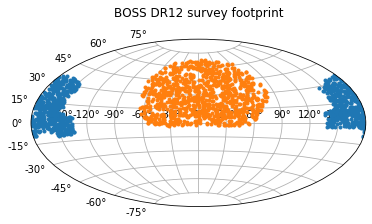

In [5]:
filename1 = 'galaxy_DR12v5_CMASSLOWZTOT_South.fits'
data_south = read_data(filename1)
filename2 = 'galaxy_DR12v5_CMASSLOWZTOT_North.fits'
data_north = read_data(filename2)
plot_data(data_south, data_north)


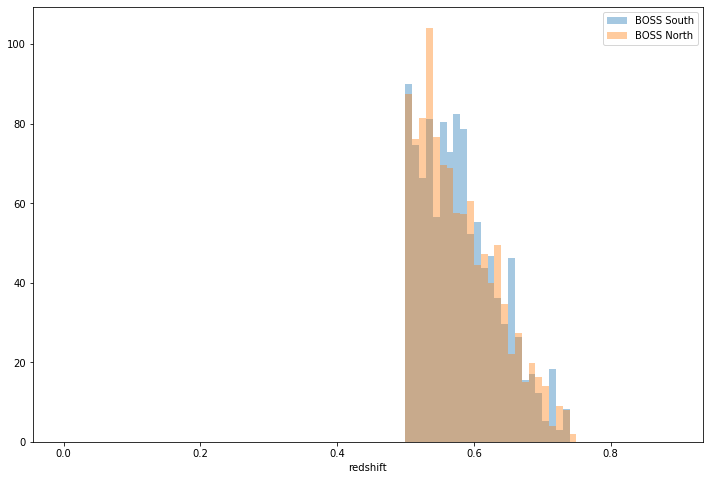

In [109]:
# to plot this distribuiton you need to change the zmin = 0.01 and zmax = 0.9
plot_redshit(data_south,data_north)



In [110]:
#transform the map to cartesian coodinates
galaxies_cat_1 = data_south
galaxies_cat_2 = data_north
    
galaxies_cat_1['Position'] = nbodykit.transform.SkyToCartesian(galaxies_cat_1['RA'],\
galaxies_cat_1['DEC'], galaxies_cat_1['Z'], cosmo=cosmo)
galaxies_cat_2['Position'] = nbodykit.transform.SkyToCartesian(galaxies_cat_2['RA'],\
galaxies_cat_2['DEC'], galaxies_cat_2['Z'], cosmo=cosmo)

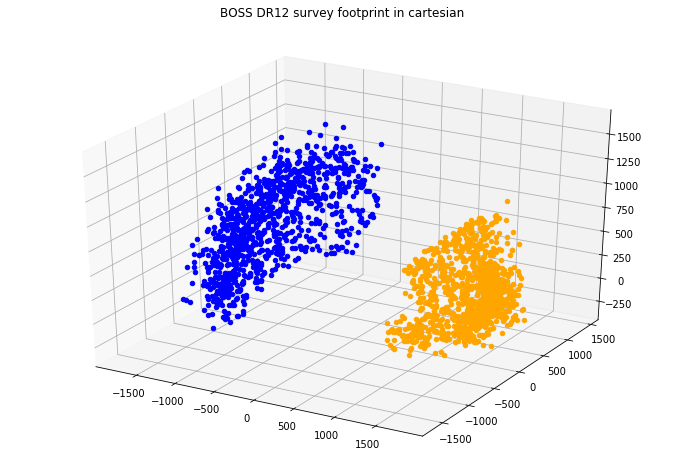

In [111]:
plot_mapcartesian(data_south,data_north)

Map the distribuitons of the galaxy using diferents  $\Omega_{cdm}$

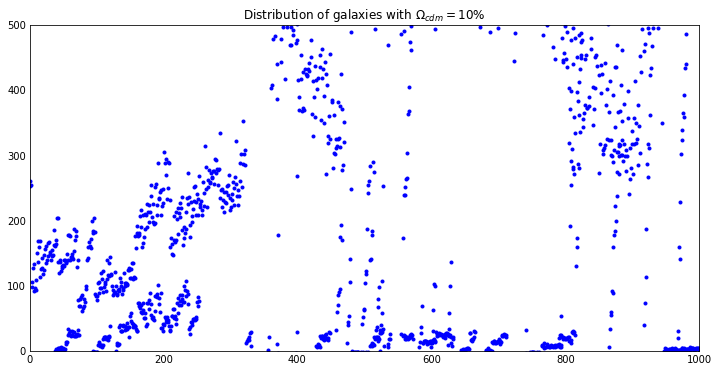

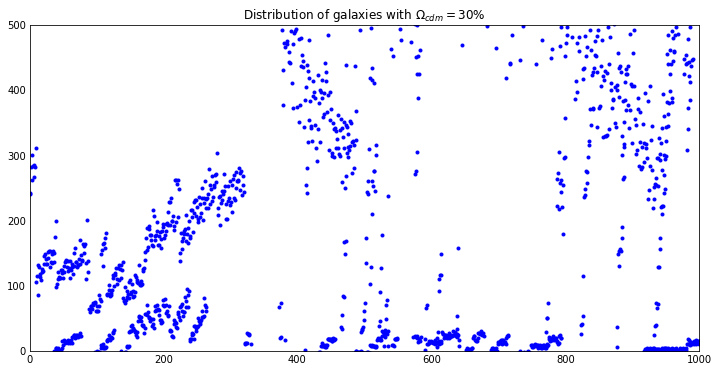

In [112]:
cosmo1 = nbodykit.lab.cosmology.Cosmology(Omega0_cdm=0.10, Omega0_b=0.045, h=0.7)


galaxies_cat_1_1 = down_sample(data_south, 10000)
galaxies_cat_2_1 = down_sample(data_north, 10000)

galaxies_cat_1_1['Position'] = nbodykit.transform.SkyToCartesian(galaxies_cat_1_1['RA'],\
galaxies_cat_1_1['DEC'], galaxies_cat_1_1['Z'], cosmo=cosmo1)
galaxies_cat_2_1['Position'] = nbodykit.transform.SkyToCartesian(galaxies_cat_2_1['RA'],\
galaxies_cat_2_1['DEC'], galaxies_cat_2_1['Z'], cosmo=cosmo1)
     
position_1_1 = galaxies_cat_1_1.compute(galaxies_cat_1_1['Position'])
position_2_1 = galaxies_cat_2_1.compute(galaxies_cat_2_1['Position'])


cosmo2 = nbodykit.lab.cosmology.Cosmology(Omega0_cdm=0.30, Omega0_b=0.045, h=0.7)

galaxies_cat_1_2 = down_sample(data_south, 10000)
galaxies_cat_2_2 = down_sample(data_north, 10000)


galaxies_cat_1_2['Position'] = nbodykit.transform.SkyToCartesian(galaxies_cat_1_2['RA'],\
galaxies_cat_1_2['DEC'], galaxies_cat_1_2['Z'], cosmo=cosmo2)
galaxies_cat_2_2['Position'] = nbodykit.transform.SkyToCartesian(galaxies_cat_2_2['RA'],\
galaxies_cat_2_2['DEC'], galaxies_cat_2_2['Z'], cosmo=cosmo2)
     
position_1_2 = galaxies_cat_1_2.compute(galaxies_cat_1_2['Position'])
position_2_2 = galaxies_cat_2_2.compute(galaxies_cat_2_2['Position'])

plt.rcParams['figure.figsize'] = [12,6]

plt.figure()
plt.tick_params(axis='both', which='major', labelleft='off', labelbottom='off', size=0.)
plt.title("Distribution of galaxies with $\Omega_{cdm} = 10%$%")
plt.xlim((0, 1000.))
plt.ylim((0, 500))
plt.plot(position_1_1,'.',c = 'blue')
plt.plot(position_2_1,'.', c = 'blue')
#plt.show()

plt.figure()
plt.tick_params(axis='both', which='major', labelleft='off', labelbottom='off', size=0.)
plt.title("Distribution of galaxies with $\Omega_{cdm} = 30$%")

plt.xlim((0, 1000.))
plt.ylim((0, 500))
plt.plot(position_1_2,'.',c = 'blue')
plt.plot(position_2_2,'.', c = 'blue')
plt.show()


    

3. Extract the Power spectrum 

In [113]:
#Functions to read #
def read_ran(filename):
    ''' Read the random catalogues '''
    randoms_cat = nbodykit.lab.FITSCatalog(os.path.join(base_dir, filename))
    print('randoms_cat.columns = ', randoms_cat.columns)
    randoms_cat = randoms_cat[(randoms_cat['Z'] > zmin) & (randoms_cat['Z'] < zmax)]
    return randoms_cat

In [114]:
filename_1 = 'random0_DR12v5_CMASSLOWZTOT_South.fits'
data_south_random = read_ran(filename_1)
filename2 = 'random0_DR12v5_CMASSLOWZTOT_North.fits'
data_north_random = read_ran(filename2)

randoms_cat.columns =  ['AIRMASS', 'DEC', 'EB_MINUS_V', 'IMAGE_DEPTH', 'IPOLY', 'ISECT', 'NZ', 'PSF_FWHM', 'RA', 'SKYFLUX', 'Selection', 'Value', 'WEIGHT_FKP', 'Weight', 'Z', 'ZINDX']
randoms_cat.columns =  ['AIRMASS', 'DEC', 'EB_MINUS_V', 'IMAGE_DEPTH', 'IPOLY', 'ISECT', 'NZ', 'PSF_FWHM', 'RA', 'SKYFLUX', 'Selection', 'Value', 'WEIGHT_FKP', 'Weight', 'Z', 'ZINDX']


In [115]:
# Tranform and adding Postition column to data

data_south_random['Position'] = nbodykit.transform.SkyToCartesian(data_south_random['RA'], data_south_random['DEC'], 
data_south_random['Z'], cosmo=cosmo)
data_north_random['Position'] = nbodykit.transform.SkyToCartesian(data_north_random['RA'], data_north_random['DEC'], 
data_north_random['Z'], cosmo=cosmo)

In [116]:
# Combine data and random catalogue

# South data
fkp_s = nbodykit.lab.FKPCatalog(data_south, data_south_random)
# Assign point distribution to 3D grid
mesh_s = fkp_s.to_mesh(Nmesh=512, nbar='NZ', comp_weight='Weight', fkp_weight='FKPWeight')
# Calculate power spectrum (monopole only)
r_s = nbodykit.lab.ConvolvedFFTPower(mesh_s, poles=[0], dk=0.01, kmin=0.01)

#North data
fkp_n = nbodykit.lab.FKPCatalog(data_north,data_north_random)
# Assign point distribution to 3D grid
mesh_n = fkp_n.to_mesh(Nmesh=512, nbar='NZ', comp_weight='Weight', fkp_weight='FKPWeight')
#Calculate power spectrum (monopole only)
r_n = nbodykit.lab.ConvolvedFFTPower(mesh_n, poles=[0], dk=0.01,kmin=0.01)


    the plot with shot noise

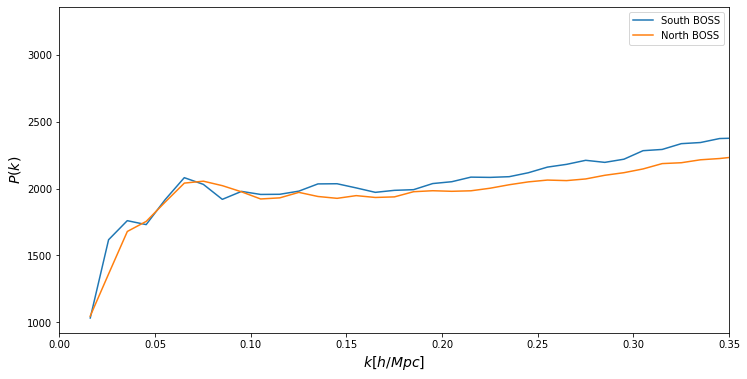

In [117]:
#plot

plt.plot(r_s.poles['k'], r_s.poles['k']*(r_s.poles['power_0'].real), label = 'South BOSS')
plt.plot(r_n.poles['k'], r_n.poles['k']*(r_n.poles['power_0'].real), label='North BOSS')
plt.xlim(0,0.35)
plt.xlabel('$k[h/Mpc]$', fontsize=14)
plt.ylabel('$P(k)$', fontsize=14)
plt.legend()
plt.savefig('comparacao2.png')
plt.show()
plt.close()

In [118]:
# Get the data power spectra
pk_file = output_path + "/pk_South.pickle"
pickle.dump( r_s.poles, open( pk_file, "wb" ) )
if os.path.isfile(pk_file):
    pk_south = pickle.load( open( pk_file, "rb" ) )
pk_file = output_path + "/pk_North.pickle"
pickle.dump(r_n.poles, open( pk_file, "wb" ) )
if os.path.isfile(pk_file):
    pk_north = pickle.load( open( pk_file, "rb" ) )
P_south = pk_south['power_0'].real - pk_south.attrs['shotnoise']
P_north = pk_north['power_0'].real - pk_north.attrs['shotnoise']

Without shotnoise

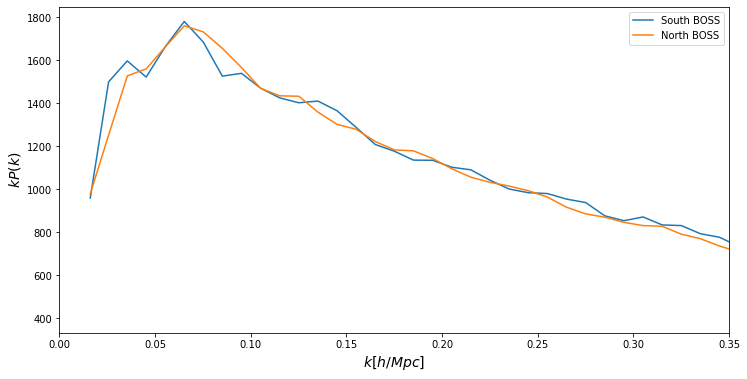

In [119]:
plt.plot(r_s.poles['k'], r_s.poles['k']*(P_south), label = 'South BOSS')
plt.plot(r_n.poles['k'], r_n.poles['k']*(P_north), label='North BOSS')
plt.xlim(0,0.35)
plt.xlabel('$k[h/Mpc]$', fontsize=14)
plt.ylabel('$kP(k)$', fontsize=14)
plt.legend()
plt.savefig('comparacao.png')
plt.show()
plt.close()

Plot the power spectra acquired using CLASSto compare 

In [6]:
# create instance of the class "Class"
LambdaCDM = Class()
# pass input parameters
LambdaCDM.set({'omega_b':0.022032,'omega_cdm':0.30,'h':0.67556,'A_s':2.215e-9,'n_s':0.9619,'tau_reio':0.0925})
LambdaCDM.set({'output':'tCl,pCl,lCl,mPk','lensing':'yes','P_k_max_1/Mpc':3.0})
# run class
LambdaCDM.compute()

In [7]:
# CLASS power spectra at z =0

kk = np.logspace(-4,np.log10(3),1000) # k in h/Mpc
Pk = [] # P(k) in (Mpc/h)**3
h = LambdaCDM.h() # get reduced Hubble for conversions to 1/Mpc
for k in kk:
    Pk.append(LambdaCDM.pk(k*h,0.)*h**3) # function .pk(k,z)

In [8]:
# create instance of the class "Class"
LambdaCDM = Class()
# pass input parameters
LambdaCDM.set({'omega_b':0.022032,'omega_cdm':0.10,'h':0.67556,'A_s':2.215e-9,'n_s':0.9619,'tau_reio':0.0925})
LambdaCDM.set({'output':'tCl,pCl,lCl,mPk','lensing':'yes','P_k_max_1/Mpc':3.0})
# run class
LambdaCDM.compute()

In [9]:
kk1 = np.logspace(-4,np.log10(3),1000) # k in h/Mpc
Pk1 = [] # P(k) in (Mpc/h)**3
h1 = LambdaCDM.h() # get reduced Hubble for conversions to 1/Mpc
for k1 in kk1:
    Pk1.append(LambdaCDM.pk(k1*h1,0.)*h1**3) # function .pk(k,z)

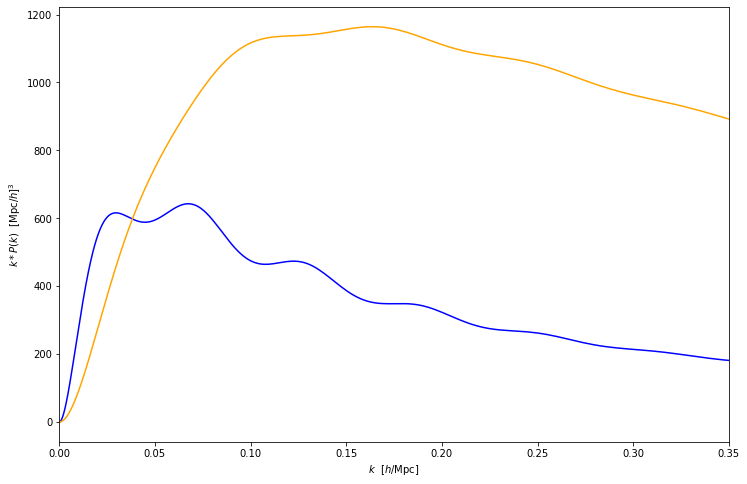

In [10]:
# plot P(k)
plt.figure(2)
#plt.xscale('log');#plt.yscale('log');
#plt.xlim(kk[0],kk[-1])
plt.xlim(0,0.35)
#plt.ylim(0,900)
plt.xlabel(r'$k \,\,\,\, [h/\mathrm{Mpc}]$')
plt.ylabel(r'$k*P(k) \,\,\,\, [\mathrm{Mpc}/h]^3$')
#plt.legend('$\Lambda_{cdm}= 0.3$', '$\Lambda_{cdm}= 0.1$')
plt.plot(kk1,kk1*Pk1, color = 'blue')
plt.plot(kk,kk*Pk,color= 'orange')

4. Estimate of the uncertainty on the measurements

In [121]:
#Function to read the data
def read_sim_data(filename):
    ''' Read the random simulation catalogues from CSV '''
    sim_cat = nbodykit.lab.CSVCatalog(os.path.join(base_dir, filename),\
        names=['RA', 'DEC', 'Z', 'dummy1', 'NZ', 'dummy2', 'veto', 'Weight'])
    print('sim_cat.columns = ', sim_cat.columns)
    sim_cat = sim_cat[(sim_cat['Z'] > zmin) & (sim_cat['Z'] < zmax)]
    sim_cat = sim_cat[(sim_cat['veto'] > 0)]
    sim_cat['WEIGHT_FKP'] = 1./(1. + 10000.*sim_cat['NZ']);
    return sim_cat

def read_sim_ran(filename):
    ''' Read the simulation catalogues from CSV '''
    ran_cat = nbodykit.lab.CSVCatalog(os.path.join(base_dir, filename),\
        names=['RA', 'DEC', 'Z', 'NZ', 'dummy1', 'veto', 'Weight'])
    print('ran_cat.columns = ', ran_cat.columns)
    ran_cat = ran_cat[(ran_cat['Z'] > zmin) & (ran_cat['Z'] < zmax)]
    ran_cat = ran_cat[(ran_cat['veto'] > 0)]
    ran_cat['WEIGHT_FKP'] = 1./(1. + 10000.*ran_cat['NZ']);
    return ran_cat

In [122]:
#Fucntion to processe the covariace matrix data

def process_sims(cosmo, tag, N):
    ''' Calculate the covariance matrix using the simulated BOSS datasets '''
    # Read the random catalogue which can be paired with all of the simulated catalogues
    filename = 'Patchy-Mocks-Randoms-DR12%s-COMPSAM_V6C_x50.dat' % tag
    random = read_sim_ran(filename)

    for i in range(1, N):
        pk_file = output_path + "/sims/pk_%s_%d.pickle" % (tag, i)
        print('calculating %s... ' % pk_file)
        # Only calculate power spectra which we don't have on disk
        if not os.path.isfile(pk_file):
            filename = 'Patchy-Mocks-DR12%s-COMPSAM_V6C/Patchy-Mocks-DR12%s-COMPSAM_V6C_%0.4d.dat' % (tag, tag, i)
            sim = read_sim_data(filename)
            pk = calc_pk(cosmo, sim, random)
            # store the power spectra 
            pickle.dump( pk, open( pk_file, "wb" ) )
    return calc_cov(tag, N)

def process_sims_with_MPI(cosmo, tag, N):
    ''' Calculate the covariance matrix using the simulated BOSS datasets '''
    # this splits the communicator into chunks of size of roughly N
    with nbodykit.lab.TaskManager(1, use_all_cpus=True) as tm:
        # Read the random catalogue which can be paired with
        # all of the simulated catalogues
        filename = 'Patchy-Mocks-Randoms-DR12%s-COMPSAM_V6C_x50.dat' % tag
        random = read_sim_ran(filename)
        # loop over each box in parallel
        for i in tm.iterate(range(1, N)):
            pk_file = output_path + "/sims/pk_%s_%d.pickle" % (tag, i)
            print('calculating %s... ' % pk_file)
            # Only calculate power spectra which we don't have on disk
            if not os.path.isfile(pk_file):
                filename = ("Patchy-Mocks-DR12%s-COMPSAM_V6C/Patchy-"
                            Mocks-DR12%s-COMPSAM_V6C_%0.4d.dat" % (tag, tag, i))
                sim = read_sim_data(filename)
                pk = calc_pk(cosmo, sim, random)
                # store the power spectra 
                pickle.dump( pk, open( pk_file, "wb" ) )
    return calc_cov(tag, N)
def calc_cov(tag, N):
    ''' Read simulation power spectra and return covariance matrix '''
    list_of_pks = []
    for i in range(1, N):
        pk_file = output_path + "/sims/pk_%s_%d.pickle" % (tag, i)
        pk = pickle.load( open( pk_file, "rb" ) )
        P = pk['power_0'].real - pk.attrs['shotnoise']
        # Limit the k range
        P = P[(pk['k'] < kmax)]
        list_of_pks.append(P)
    return np.cov(np.vstack(list_of_pks).T)
def plot_cov(matrix,tag):
    ''' Plot the correlation matrix derived from the covariance matrix '''
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    plt.imshow(np.corrcoef(matrix))
    plt.colorbar()
    plt.savefig("cov%s.png" %(tag))
    plt.show()
    return 

Read the data

In [123]:
cov_south = process_sims(cosmo, 'SGC', 1000)
cov_south_inv = inv(cov_south)
cov_north = process_sims(cosmo, 'NGC', 1000)
cov_north_inv = inv(cov_north)

ran_cat.columns =  ['DEC', 'NZ', 'RA', 'Selection', 'Value', 'Weight', 'Z', 'dummy1', 'veto']
calculating Data//sims/pk_SGC_1.pickle... 
calculating Data//sims/pk_SGC_2.pickle... 
calculating Data//sims/pk_SGC_3.pickle... 
calculating Data//sims/pk_SGC_4.pickle... 
calculating Data//sims/pk_SGC_5.pickle... 
calculating Data//sims/pk_SGC_6.pickle... 
calculating Data//sims/pk_SGC_7.pickle... 
calculating Data//sims/pk_SGC_8.pickle... 
calculating Data//sims/pk_SGC_9.pickle... 
calculating Data//sims/pk_SGC_10.pickle... 
calculating Data//sims/pk_SGC_11.pickle... 
calculating Data//sims/pk_SGC_12.pickle... 
calculating Data//sims/pk_SGC_13.pickle... 
calculating Data//sims/pk_SGC_14.pickle... 
calculating Data//sims/pk_SGC_15.pickle... 
calculating Data//sims/pk_SGC_16.pickle... 
calculating Data//sims/pk_SGC_17.pickle... 
calculating Data//sims/pk_SGC_18.pickle... 
calculating Data//sims/pk_SGC_19.pickle... 
calculating Data//sims/pk_SGC_20.pickle... 
calculating Data//sims/pk_SGC_21.pi

ran_cat.columns =  ['DEC', 'NZ', 'RA', 'Selection', 'Value', 'Weight', 'Z', 'dummy1', 'veto']
calculating Data//sims/pk_NGC_1.pickle... 
calculating Data//sims/pk_NGC_2.pickle... 
calculating Data//sims/pk_NGC_3.pickle... 
calculating Data//sims/pk_NGC_4.pickle... 
calculating Data//sims/pk_NGC_5.pickle... 
calculating Data//sims/pk_NGC_6.pickle... 
calculating Data//sims/pk_NGC_7.pickle... 
calculating Data//sims/pk_NGC_8.pickle... 
calculating Data//sims/pk_NGC_9.pickle... 
calculating Data//sims/pk_NGC_10.pickle... 
calculating Data//sims/pk_NGC_11.pickle... 
calculating Data//sims/pk_NGC_12.pickle... 
calculating Data//sims/pk_NGC_13.pickle... 
calculating Data//sims/pk_NGC_14.pickle... 
calculating Data//sims/pk_NGC_15.pickle... 
calculating Data//sims/pk_NGC_16.pickle... 
calculating Data//sims/pk_NGC_17.pickle... 
calculating Data//sims/pk_NGC_18.pickle... 
calculating Data//sims/pk_NGC_19.pickle... 
calculating Data//sims/pk_NGC_20.pickle... 
calculating Data//sims/pk_NGC_21.pi

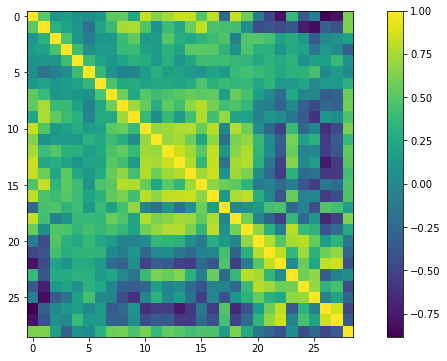

In [124]:
plot_cov(cov_south,'SGC')


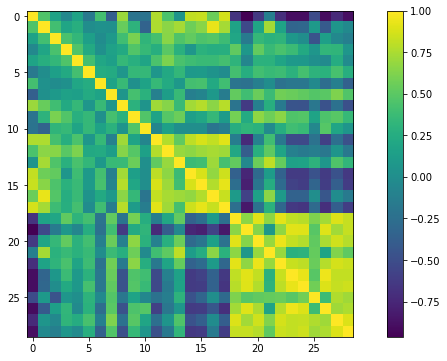

In [125]:
plot_cov(cov_north,'NGC')

In [126]:
# Store power spectrum details in a dictionary
boss_data = [{ 'k': pk_south['k'][(pk_south['k'] < kmax)], 'pk': P_south[(pk_south['k'] < kmax)],\
'label': 'BOSS south', 'cov': cov_south, 'cov_inv': cov_south_inv},\
{ 'k': pk_north['k'][(pk_north['k'] < kmax)], 'pk': P_north[(pk_north['k'] < kmax)],\
'label': 'BOSS north', 'cov': cov_north, 'cov_inv': cov_north_inv }]

In [127]:
def cmp_pk_with_error(pk1, pk2):
    ''' Compare two power spectra including uncertainties'''
    plt.clf()
    
    plt.errorbar(pk1['k'], pk1['k']*pk1['pk'], yerr=pk1['k']*np.sqrt(np.diagonal(pk1['cov'])),\
        marker='.', linestyle = 'None', label=pk1['label'])
    plt.errorbar(pk2['k'], pk2['k']*pk2['pk'], yerr=pk2['k']*np.sqrt(np.diagonal(pk2['cov'])),\
        marker='.', linestyle = 'None', label=pk2['label'])
    plt.legend(loc=0)
    plt.xlabel("k [$h$Mpc$^{-1}$]")
    plt.ylabel("kP [$h^{-2}$ Mpc$^2$]")
    plt.xlim(kmin, kmax)
    plt.show()
    return


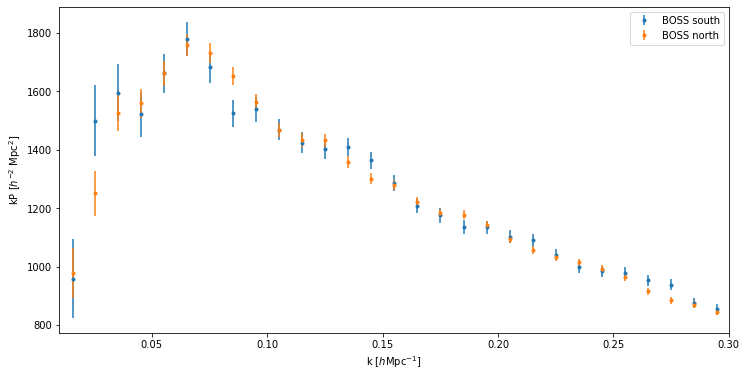

In [128]:
cmp_pk_with_error(boss_data[0],boss_data[1])   

In [129]:
def cmp_pk_with_error1b(pk1, pk2):
    ''' Compare two power spectra including uncertainties'''
    plt.clf()
    plt.plot(pk1['k'], pk1['k']*pk1['pk'],marker='.',color = 'blue')
    plt.plot(pk2['k'], pk2['k']*pk2['pk'],marker='.',color = 'orange')
    plt.errorbar(pk1['k'], pk1['k']*pk1['pk'], yerr=pk1['k']*np.sqrt(np.diagonal(pk1['cov'])),\
        marker='.', linestyle = 'None', label=pk1['label'],color = 'blue')
    plt.errorbar(pk2['k'], pk2['k']*pk2['pk'], yerr=pk2['k']*np.sqrt(np.diagonal(pk2['cov'])),\
        marker='.', linestyle = 'None', label=pk2['label'],color = 'orange')
    plt.legend(loc=0)
    plt.xlabel("k [$h$Mpc$^{-1}$]")
    plt.ylabel("kP [$h^{-2}$ Mpc$^2$]")
    plt.xlim(kmin, kmax)
    plt.show()
    return


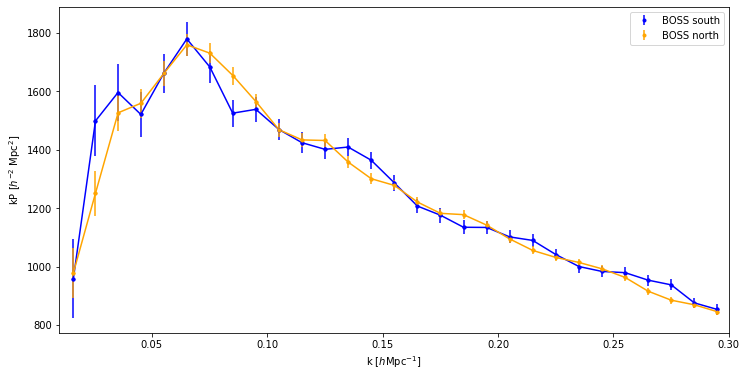

In [130]:
cmp_pk_with_error1b(boss_data[0],boss_data[1])   

4. Extract the informations of $P(k)$ and minimizing the $\chi^2$

(0.0, 0.35)

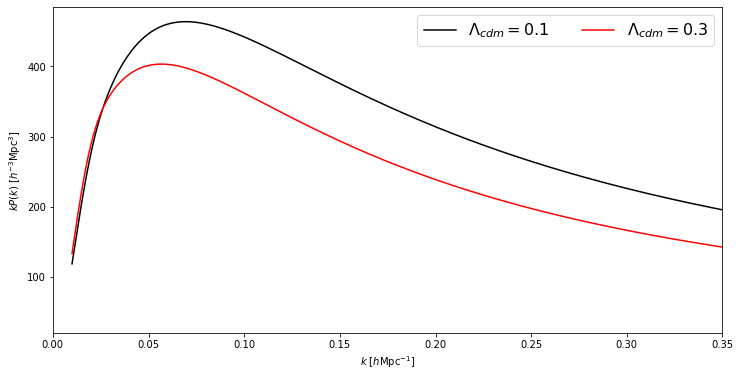

In [170]:
Plin = nbodykit.lab.cosmology.power.linear.LinearPower(cosmo, redshift=0.5, transfer='NoWiggleEisensteinHu',)
k = np.logspace(-2, 0, 512)

Plin2 = nbodykit.lab.cosmology.power.linear.LinearPower(cosmo2,redshift=0.5,transfer='NoWiggleEisensteinHu')
k = np.logspace(-2, 0, 512)


plt.plot(k, k* Plin2(k), c='k', label='$\Lambda_{cdm}=0.1$')
plt.plot(k, k* Plin(k), c='r', label='$\Lambda_{cdm}=0.3$')

# add a legend and axes labels
plt.legend(loc=0, ncol=2, fontsize=16)
plt.xlabel(r"$k$ [$h \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$kP(k)$ [$h^{-3} \mathrm{Mpc}^3$]")
plt.xlim(0.0, 0.35)


In [132]:
##### Functions 
def get_smooth_model(parameters, x, templates):
    ''' Combine a noBAO model with polynomials and linear bias '''
    polynomials = parameters[1]/x**3 + parameters[2]/x**2 + parameters[3]/x + parameters[4] + parameters[5]*x
    return parameters[0]*parameters[0]*templates['noBAO'](x) + polynomials
def get_oscillation(krange, Pk_class, Pk_without_BAO):
    ''' Get an oscillation only power spectrum '''
    cov_inv = np.identity(len(krange))
    start = [1., 0., 0., 0., 0., 0.]
    result = op.minimize(calc_chi2, start, args=( [{ 'k': krange, 'pk': Pk_class(krange), 'cov_inv': cov_inv }],\
     { 'noBAO': Pk_without_BAO }, get_smooth_model))
    yolin = Pk_class(krange)/get_smooth_model(result["x"], krange, { 'noBAO': Pk_without_BAO })
    return interp.interp1d(krange, yolin)
def get_shifted_model(parameters, x, templates):
    ''' Calculate a model including a shift given by alpha '''
    model = get_smooth_model(parameters, x, templates)
    return model*(1. + (templates['os_model'](x/parameters[6]) - 1.)*np.exp(-0.5*x**2*parameters[7]**2))
def within_priors(parameters):
    ##Test for priors
    if  len(parameters) > 6 and abs(parameters[6] - 1.) > 0.2:
        return False
    elif len(parameters) > 6. and (parameters[7] < 0. or parameters[7] > 20.):
        return False
    else:
        return True
    
def calc_chi2(parameters, data, templates, func):
    ''' Compares the model with the data '''
    if within_priors(parameters):
        chi2 = 0.
        # Loop over all datasets which are fit together
        for dataset in data:
            model = func(parameters, dataset['k'], templates)
            diff = (model - dataset['pk'])
            chi2 += np.dot(diff,np.dot(dataset['cov_inv'],diff))
        return chi2
    else:
        return 100000.
def cmp_ratio_with_error(pk1, pk2, models=[]):
    ''' Compare two power spectra including uncertainties'''
    plt.clf()
    for model in models:
        plt.plot(model['k'], model['pk'])
    plt.errorbar(pk1['k'], pk1['ratio'], yerr=pk1['ratio_err'], marker='.',\
     linestyle = 'None', label=pk1['label'])
    plt.errorbar(pk2['k'], pk2['ratio'], yerr=pk2['ratio_err'], marker='.',\
     linestyle = 'None', label=pk2['label'])
    plt.axhline(y=1., color='black', linestyle='--')
    plt.legend(loc=0)
    plt.xlabel("k [$h$Mpc$^{-1}$]")
    plt.ylabel("$P(k)/P^{noBAO}(k)$")
    plt.xlim(kmin, kmax)
    plt.savefig("cmp_ratio_with_error")
    plt.show()
    return    


In [140]:
# Isolate the BAO signal 
Pk_without_BAO = nbodykit.lab.cosmology.power.linear.LinearPower(cosmo, redshift=0, transfer='NoWiggleEisensteinHu')
Pk_class = nbodykit.lab.cosmology.power.linear.LinearPower(cosmo, redshift=0, transfer='CLASS')
krange = np.arange(0.001, 0.5, 0.001)
os_model = get_oscillation(krange, Pk_class, Pk_without_BAO)
start = [2.37, -0.076, 38., -3547., 15760., -22622., 1., 9.41]
result = op.minimize(calc_chi2, start, args=(boss_data, { 'noBAO': Pk_without_BAO, 'os_model': os_model },\
get_shifted_model))
print("result['x'] = ", result['x'])

result['x'] =  [ 2.38774786e+00 -1.47427448e-01  4.43605352e+01 -3.79576413e+03
  1.67608592e+04 -2.38719897e+04  9.97996589e-01  1.10862632e+01]


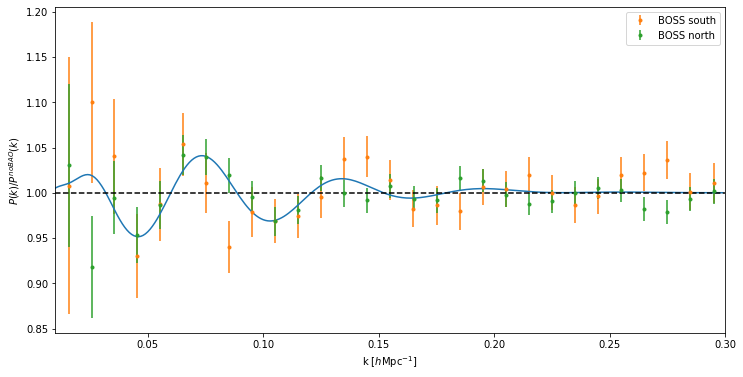

In [134]:
krange = np.arange(kmin, kmax, 0.001)
best_fit_model = get_shifted_model(result["x"], krange, { 'noBAO': Pk_without_BAO, 'os_model': os_model })/get_smooth_model(result["x"], krange, { 'noBAO': Pk_without_BAO })
boss_data[0]['ratio'] = boss_data[0]['pk']/get_smooth_model(result["x"], boss_data[0]['k'], { 'noBAO': Pk_without_BAO })
boss_data[0]['ratio_err'] = np.sqrt(np.diagonal(boss_data[0]['cov']))/get_smooth_model(result["x"], boss_data[0]['k'], { 'noBAO': Pk_without_BAO })
boss_data[1]['ratio'] = boss_data[1]['pk']/get_smooth_model(result["x"], boss_data[1]['k'], { 'noBAO': Pk_without_BAO })
boss_data[1]['ratio_err'] = np.sqrt(np.diagonal(boss_data[1]['cov']))/get_smooth_model(result["x"], boss_data[1]['k'], { 'noBAO': Pk_without_BAO })
cmp_ratio_with_error(boss_data[0], boss_data[1], [{ 'k': krange, 'pk': best_fit_model }])

5. Monte Carlos Markov Chain

In [135]:
# Functions
# this functions are from Florian Beutler
def get_loglike(parameters, data, templates, func):
    return -0.5*calc_chi2(parameters, data, templates, func)

def get_percentiles(chain, labels):
    ''' Calculate constraints and uncertainties from MCMC chain '''
    per = np.percentile(chain, [50., 15.86555, 84.13445, 2.2775, 97.7225], axis=0)
    per = np.array([per[0], per[0]-per[1], per[2]-per[0], per[0]-per[3], per[4]-per[0]])
    for i in range(0, len(per[0])):
        print("%s = %f +%f -%f +%f -%f" % (labels[i], per[0][i], per[1][i], per[2][i], per[3][i], per[4][i]))
    return per

def inspect_chain(list_of_samplers, labels=[]):
    ''' Print chain properties '''
    Nchains = len(list_of_samplers)
    dim = list_of_samplers[0].chain.shape[2]
    if not labels:
        # set default labels
        labels = [('para_%i' % i) for i in range(0,dim)]

    mergedsamples = []
    for jj in range(0, Nchains):
        chain_length = list_of_samplers[jj].chain.shape[1]
        mergedsamples.extend(list_of_samplers[jj].chain[:, int(chain_length/2):, :].reshape((-1, dim)))

    # write out chain
    res = open("%schain.dat" % output_path, "w")
    for row in mergedsamples:
        for el in row:
            res.write("%f " % el)
        res.write("\n")
    res.close()

    print("length of merged chain = ", len(mergedsamples))
    try:
        for jj in range(0, Nchains):
            print("Mean acceptance fraction for chain ", jj,": ", np.mean(list_of_samplers[jj].acceptance_fraction))
    except Exception as e:
        print("WARNING: %s" % str(e))
    try:
        for jj in range(0, Nchains):
            print("Autocorrelation time for chain ", jj,": ", list_of_samplers[jj].get_autocorr_time())
    except Exception as e:
        print("WARNING: %s" % str(e))

    try:
        fig = corner.corner(mergedsamples, quantiles=[0.16, 0.5, 0.84], plot_density=False,\
            show_titles=True, title_fmt=".3f", labels=labels)
        fig.savefig("%scorner.png")
    except Exception as e:
        print("WARNING: %s" % str(e))

    fig, axes = plt.subplots(dim, 1, sharex=True, figsize=(8, 9))
    for i in range(0, dim):
        for jj in range(0, Nchains):
            axes[i].plot(list_of_samplers[jj].chain[:, :, i].T, alpha=0.4)
        #axes[i].yaxis.set_major_locator(MaxNLocator(5))
        axes[i].set_ylabel(labels[i])
    fig.tight_layout(h_pad=0.0)
    fig.savefig("%stime_series.png")

    try:
        return get_percentiles(mergedsamples, labels)
    except Exception as e:
        print("WARNING: %s" % str(e))
        return None

def gelman_rubin_convergence(within_chain_var, mean_chain, chain_length):
    ''' Calculate Gelman & Rubin diagnostic
    # 1. Remove the first half of the current chains
    # 2. Calculate the within chain and between chain variances
    # 3. estimate your variance from the within chain and between chain variance
    # 4. Calculate the potential scale reduction parameter '''
    Nchains = within_chain_var.shape[0]
    dim = within_chain_var.shape[1]
    meanall = np.mean(mean_chain, axis=0)
    W = np.mean(within_chain_var, axis=0)
    B = np.arange(dim,dtype=np.float)
    B.fill(0)
    for jj in range(0, Nchains):
        B = B + chain_length*(meanall - mean_chain[jj])**2/(Nchains-1.)
    estvar = (1. - 1./chain_length)*W + B/chain_length
    return np.sqrt(estvar/W)

def prep_gelman_rubin(sampler):
    dim = sampler.chain.shape[2]
    chain_length = sampler.chain.shape[1]
    chainsamples = sampler.chain[:, int(chain_length/2):, :].reshape((-1, dim))
    within_chain_var = np.var(chainsamples, axis=0)
    mean_chain = np.mean(chainsamples, axis=0)
    return within_chain_var, mean_chain    
    
    
def runMCMC(start, data, templates):
    ''' Perform MCMC '''
    dim = len(start)
    Nchains = 4
    nwalkers = 20
    ichaincheck = 400
    minlength = 2000
    epsilon = 0.04        
    labels = ['b', 'A1', 'A2', 'A3', 'A4', 'A5', 'alpha', 'sigmaNL']
    expected_error = [0.1, 1., 1., 1., 1., 1., 0.05, 0.1]
    # Set up the sampler.
    pos=[]
    list_of_samplers=[]
    for jj in range(0, Nchains):
        pos.append([start + (2.*np.random.random_sample((dim,)) - 1.)*expected_error for i in range(nwalkers)])
        list_of_samplers.append(emcee.EnsembleSampler(nwalkers=nwalkers, ndim=dim, log_prob_fn=get_loglike,\
         args=(data, templates, get_shifted_model)))

    # Start MCMC
    print("Running MCMC... ")
    within_chain_var = np.zeros((Nchains, dim))
    mean_chain = np.zeros((Nchains, dim))
    scalereduction = np.arange(dim, dtype=np.float)
    scalereduction.fill(2.)

    itercounter = 0
    chainstep = minlength
    
    while any(abs(1. - scalereduction) > epsilon):
        itercounter += chainstep
        for jj in range(0, Nchains):
            for result in list_of_samplers[jj].sample(pos[jj], iterations=chainstep, store=True):
                pos[jj] = result
            #we do the convergence test on the second half of the current chain (itercounter/2)
            within_chain_var[jj], mean_chain[jj] = prep_gelman_rubin(list_of_samplers[jj])
        scalereduction = gelman_rubin_convergence(within_chain_var, mean_chain, int(itercounter/2))
        print("scalereduction = ", scalereduction)
        chainstep = ichaincheck
    # Investigate the chain and print out some metrics
    return inspect_chain(list_of_samplers, labels)


Running MCMC... 
scalereduction =  [1.01541043 1.00499038 1.0059237  1.01367366 1.01328524 1.01293974
 1.0038992  1.00604288]
length of merged chain =  80000
Mean acceptance fraction for chain  0 :  0.383725
Mean acceptance fraction for chain  1 :  0.3837
Mean acceptance fraction for chain  2 :  0.39637500000000003
Mean acceptance fraction for chain  3 :  0.387125
N/50 = 40;
tau: [148.61506761  92.10978505 131.24727527 148.12882581 146.38681854
 143.70736835  97.04973053  94.78095094]
b = 2.357351 +0.220415 -0.224061 +0.423729 -0.423253
A1 = -0.154283 +0.086500 -0.085491 +0.164280 -0.171614
A2 = 43.236329 +11.950094 -13.862174 +22.754995 -26.321206
A3 = -3644.601885 +1215.827295 -1070.601373 +2364.707423 -1991.564341
A4 = 16187.853912 +4368.614419 -4862.805905 +8140.358804 -9431.876664
A5 = -23140.540321 +6702.692843 -6208.492894 +13000.152642 -11526.937447
alpha = 0.999865 +0.024438 -0.024667 +0.054674 -0.056134
sigmaNL = 12.163723 +1.923445 -2.460664 +3.586854 -5.661660
DV = 2163.810

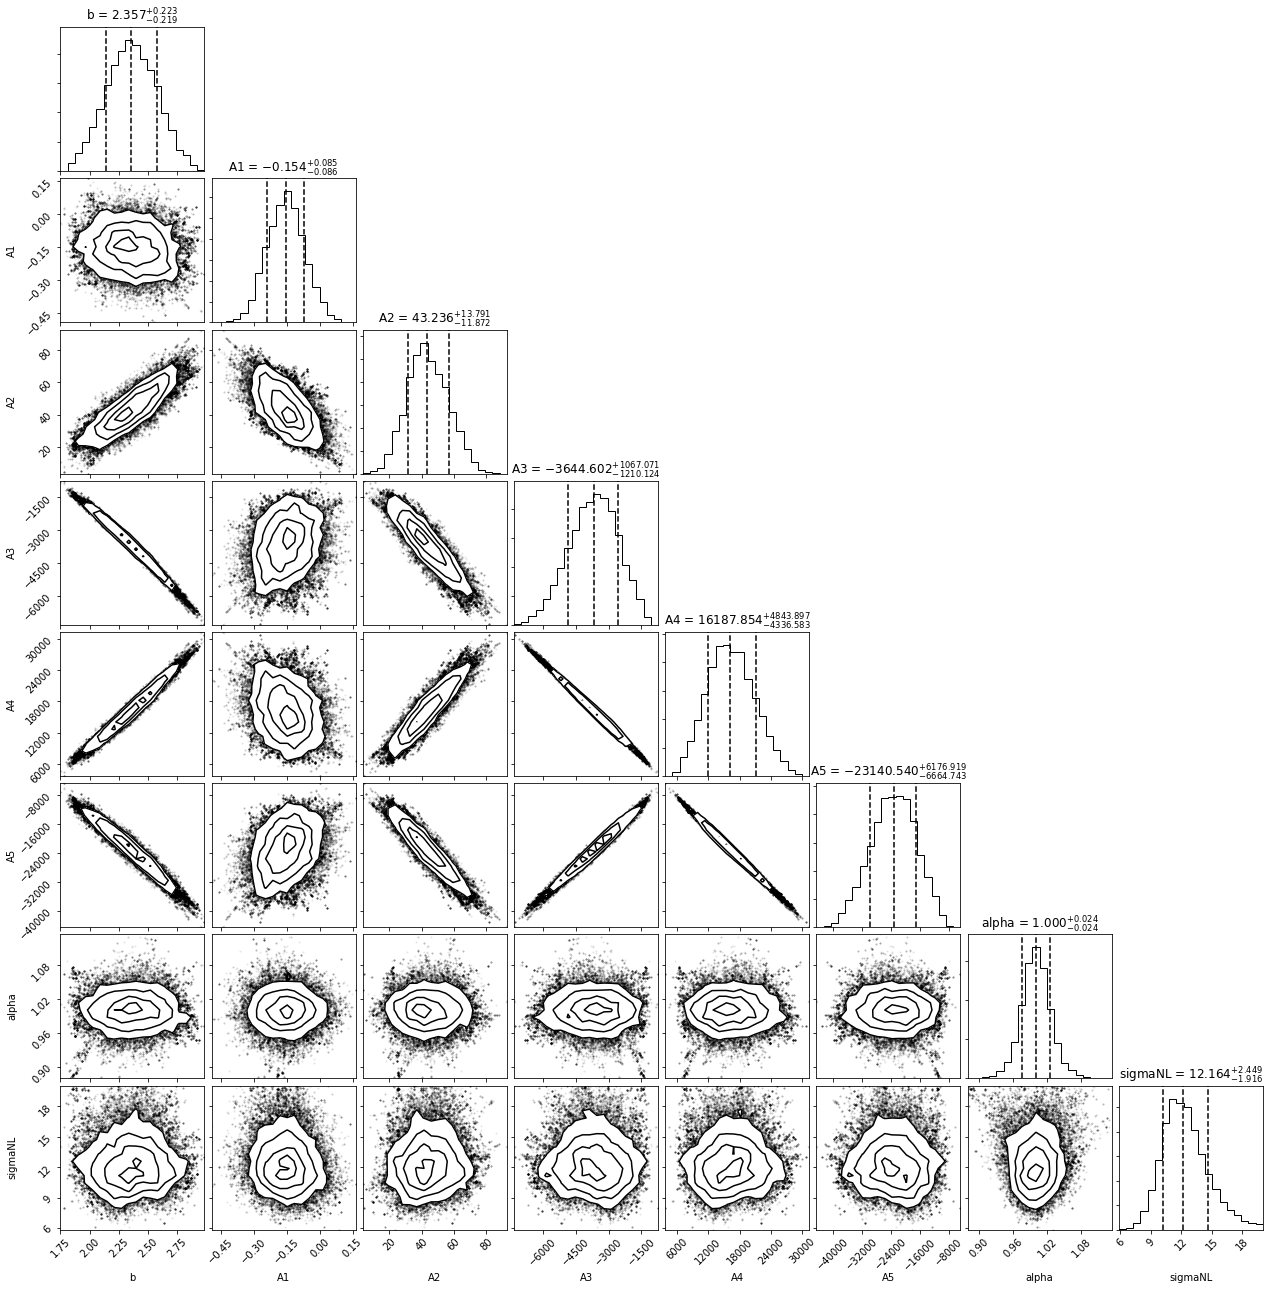

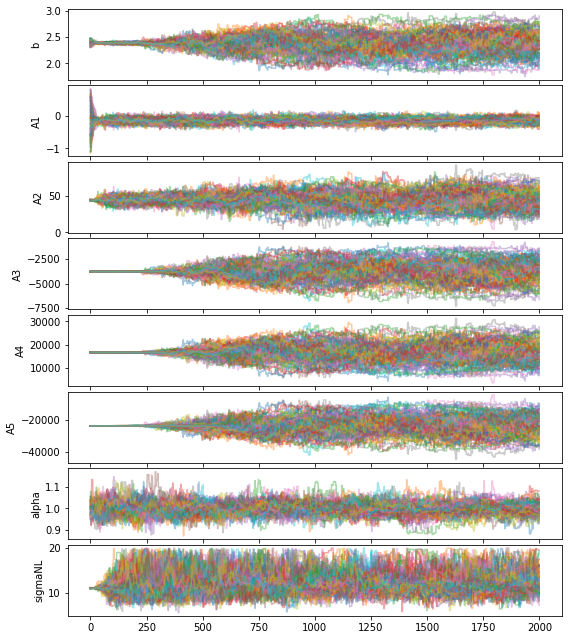

In [204]:
per = runMCMC(result['x'], boss_data, { 'noBAO': Pk_without_BAO, 'os_model': os_model })
if per is not None:
    Hz = cosmo.efunc(zmean)*cosmo.H0*cosmo.h
    DC = (1.+zmean)*cosmo.angular_diameter_distance(zmean)/cosmo.h
    c_km_s = (speed_of_light/1000.)
    DVfid = ( DC**2*(zmean*c_km_s/Hz) )**(1./3.)
    DV = per[:,6]*DVfid
    print("DV = %f +%f -%f +%f -%f\n" % (DV[0], DV[1], DV[2], DV[3], DV[4]))
else:
    print("Problem with MCMC chain")